In [ ]:
#!pip install segmentation-models-pytorch torchmetrics pytorch-lightning torchvision cartopy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import segmentation_models_pytorch as smp
import torch

import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from osgeo import gdal, osr
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import pytorch_lightning as pl
import cv2
import gc

In [2]:
dataset = "./dataset"
data_dir = pathlib.Path(dataset)
imgs = sorted(list(data_dir.glob("imgs/*/*.tif")))
masks = sorted(list(data_dir.glob("msks/*/*.tif")))

In [3]:
len(masks)

85681

## Imagens

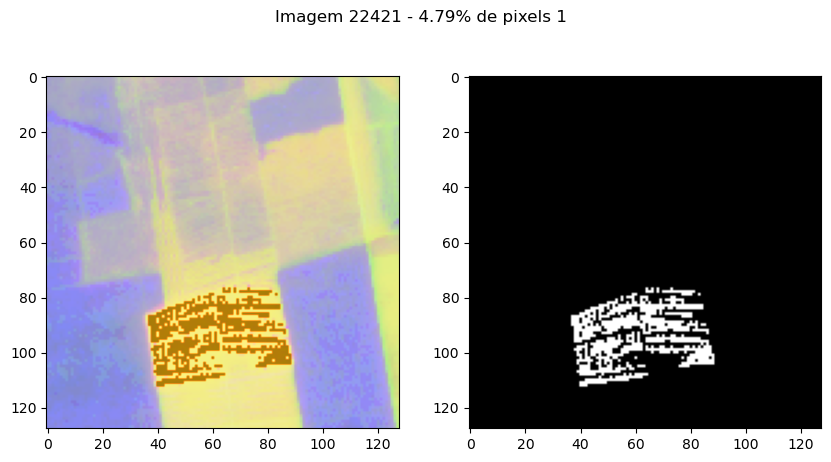

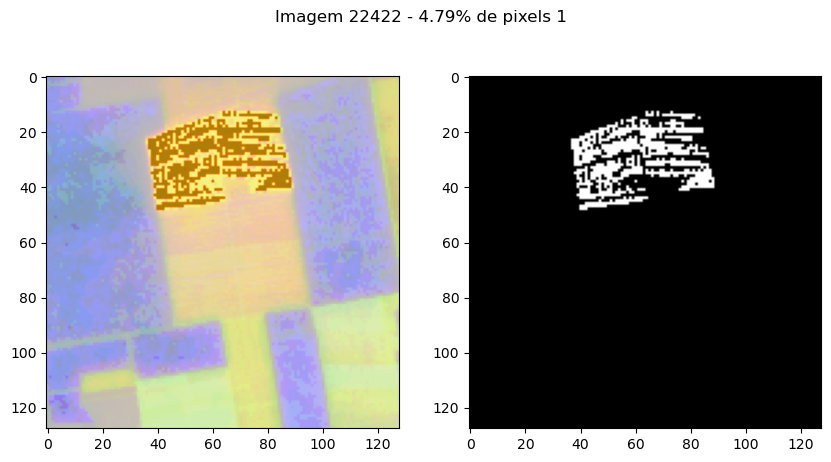

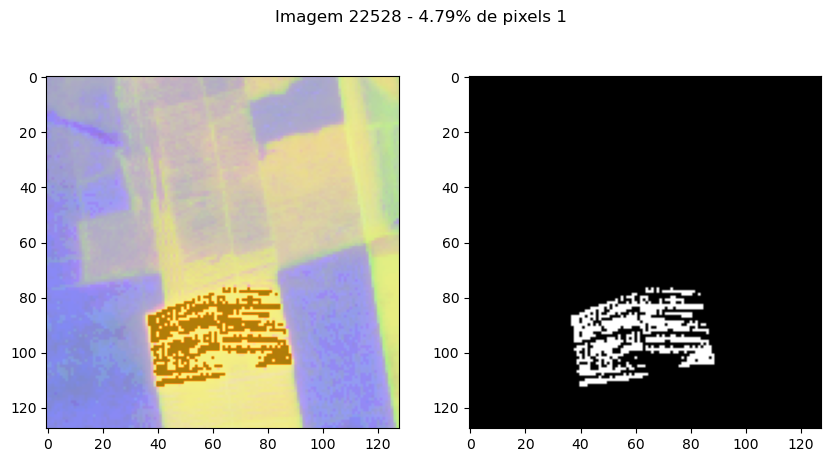

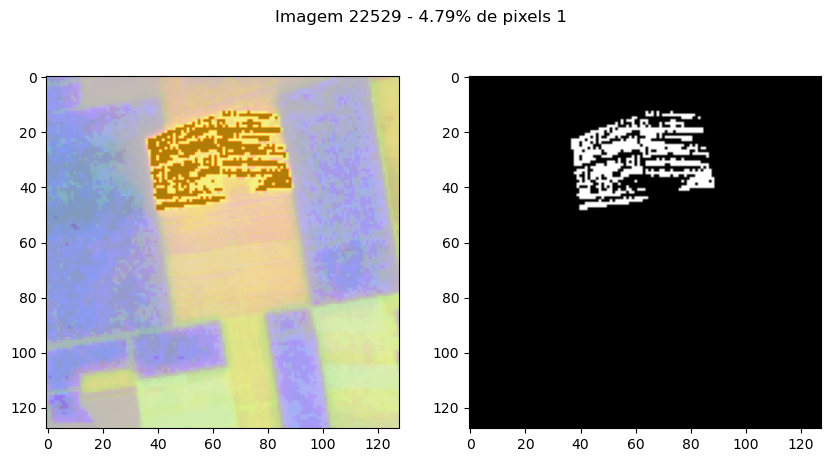

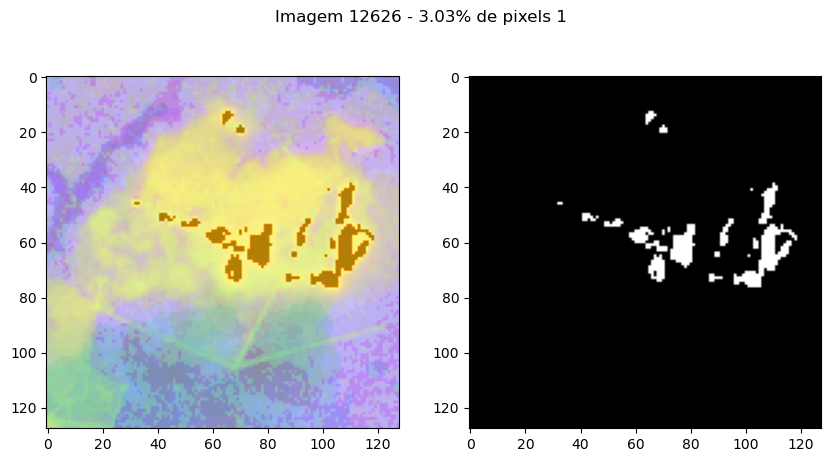

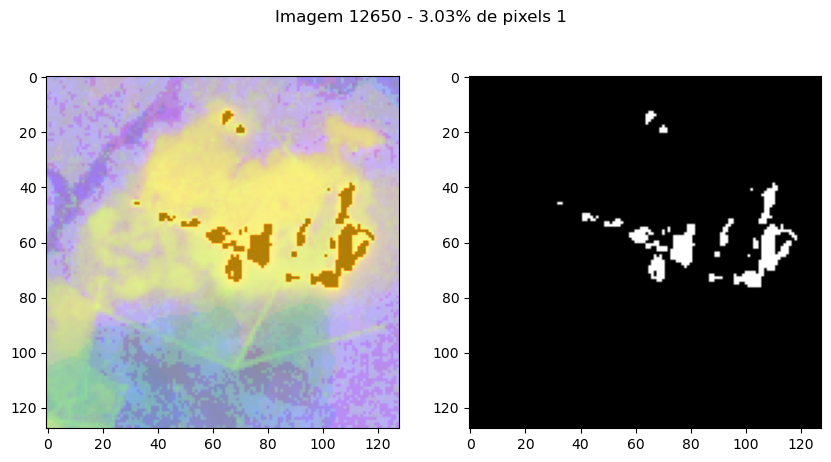

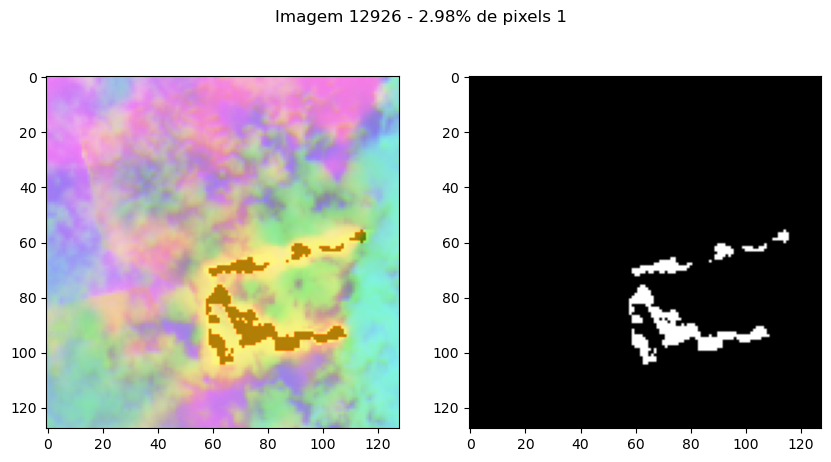

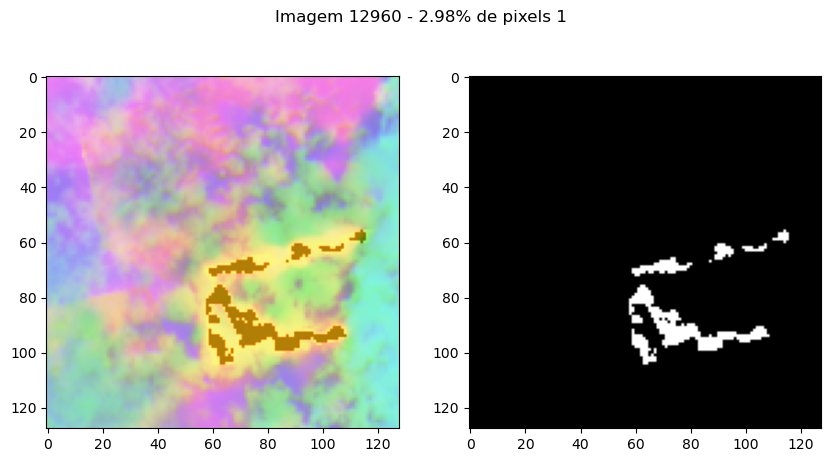

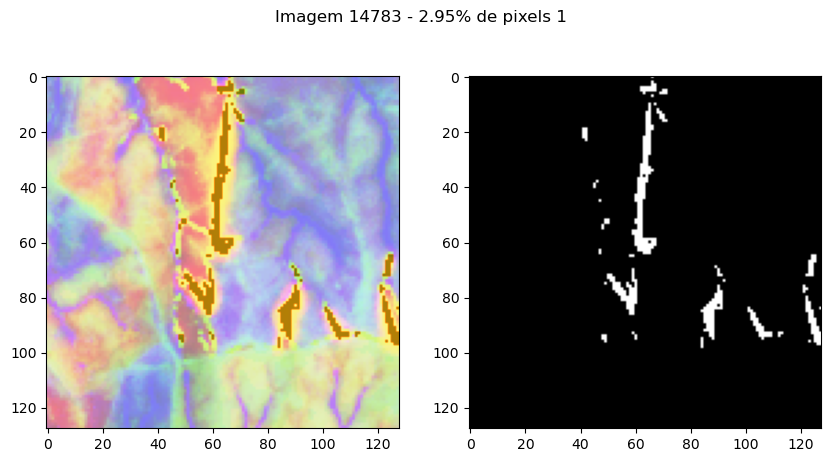

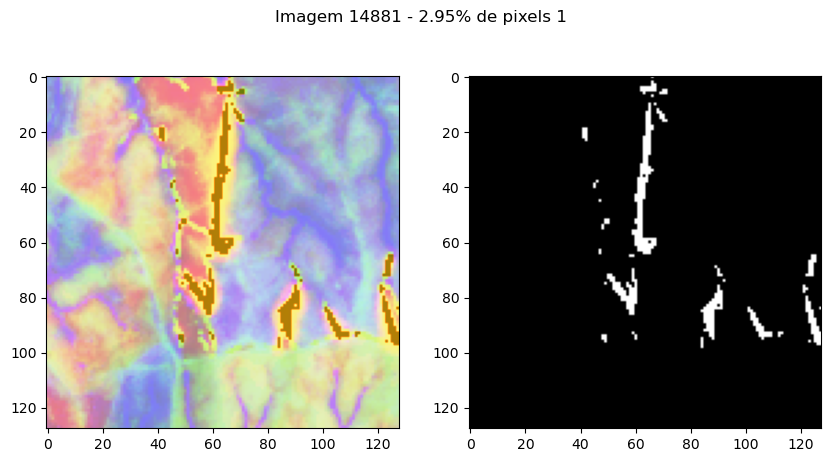

In [25]:
# Lista para armazenar as porcentagens
percent_ones = []

# Primeiro loop para calcular a porcentagem de pixels 1
for i in range(len(imgs)):
    mask = gdal.Open(str(masks[i])).ReadAsArray()
    percent = np.sum(mask == 1) / mask.size  # Percentual de pixels 1
    percent_ones.append((percent, i))  # Guardar junto com o índice da imagem

# Ordenar do maior para o menor
top_5 = sorted(percent_ones, reverse=True, key=lambda x: x[0])[:10]

# Segundo loop para exibir as 5 melhores imagens
for rank, (_, i) in enumerate(top_5):
    mask = gdal.Open(str(masks[i])).ReadAsArray()
    img = gdal.Open(str(imgs[i]))

    nir = img.GetRasterBand(5).ReadAsArray().astype(np.float32)
    swir = img.GetRasterBand(7).ReadAsArray().astype(np.float32)
    tir = img.GetRasterBand(9).ReadAsArray().astype(np.float32)

    nbr = (nir - swir) / (nir + swir + 1e-6)  # Cálculo
    del nir
    gc.collect()

    # Reescalar NBR para [0, 255] antes de converter para uint8
    nbr_scaled = ((nbr + 1) / 2 * 255).astype(np.uint8)

    # Normalizar TIRS e SWIR para [0, 255]
    tir_scaled = (tir / (tir.max() + 1e-6) * 255).astype(np.uint8)
    swir_scaled = (swir / (swir.max() + 1e-6) * 255).astype(np.uint8)

    # Criar imagem RGB com TIRS, SWIR e NBR
    rgb = np.stack([tir_scaled, swir_scaled, nbr_scaled], axis=-1)

    # Equalizar histograma
    rgb = np.stack([cv2.equalizeHist(rgb[:, :, j]) for j in range(3)], axis=-1)

    # Exibir a imagem
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Imagem {i} - {percent_ones[i][0]*100:.2f}% de pixels 1")

    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.imshow(mask, cmap="Reds", alpha=0.5)  # Sobrepor máscara

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")

    plt.show()
    del img, mask, rgb, swir, tir, nbr
    gc.collect()

In [ ]:
lat = []
lon = []

for i in masks:
    # Abrir a imagem
    msk = gdal.Open(str(i))

    # Obter transformação geoespacial
    gt = msk.GetGeoTransform()

    # Obter tamanho da imagem
    cols = msk.RasterXSize
    rows = msk.RasterYSize

    # Pixel central
    x_center = cols // 2
    y_center = rows // 2

    # Calcular coordenadas UTM (ou outra projeção da imagem)
    x_geo = gt[0] + x_center * gt[1] + y_center * gt[2]
    y_geo = gt[3] + x_center * gt[4] + y_center * gt[5]

    # Obter sistema de referência espacial (SRS)
    proj = osr.SpatialReference(wkt=msk.GetProjection())

    # Pegar EPSG do raster
    epsg_code = proj.GetAuthorityCode(None)

    if epsg_code is not None:
        epsg_code = int(epsg_code)  # Converter para inteiro

        # Criar um transformador dinâmico do EPSG da imagem para WGS84
        transformer = Transformer.from_crs(f"EPSG:{epsg_code}", "EPSG:4326", always_xy=True)

        # Converter coordenadas
        lon_wgs84, lat_wgs84 = transformer.transform(x_geo, y_geo)

        # Salvar coordenadas convertidas
        lat.append(lat_wgs84)
        lon.append(lon_wgs84)

        #print(f"Imagem: {i}, EPSG: {epsg_code}, Lat: {lat_wgs84}, Lon: {lon_wgs84}")

    else:
        print(f"EPSG não encontrado para {i}")

In [ ]:
# Criar figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar feições básicas (costas, rios, estados, países)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Definir limites do mapa (América do Sul)
ax.set_extent([-85, -30, -55, 15], crs=ccrs.PlateCarree())  # (lon_min, lon_max, lat_min, lat_max)

# Adicionar os pontos das imagens
ax.scatter(lon, lat, color='red', marker='o', s=10, transform=ccrs.PlateCarree(), label="Pontos")

# Legenda e título
ax.legend()
plt.title("Localização das Imagens do Landsat 8 na Amazônia")
plt.savefig("mapa.png", dpi=150)
plt.show()

## Divisão em Treino, Validação e Teste

In [12]:
# Função para calcular a fração de pixels 1 (fogo) na máscara
def calc_pos_ratio(mask_path):
    mask = gdal.Open(str(mask_path)).ReadAsArray()  # Carregar máscara como array
    return np.sum(mask == 1) / mask.size  # Razão de pixels fogo (1) sobre total

# Calcular a fração de fogo em cada máscara
ratios = np.array([calc_pos_ratio(mask) for mask in masks])

# Criar categorias (bins) para os valores contínuos de ratios
num_bins = min(10, len(ratios) // 2)  # Número adequado de bins (mínimo 2)
binned_ratios = pd.qcut(ratios, q=num_bins, labels=False, duplicates="drop")  # Estratificação mais equilibrada

In [17]:
np.save("estrat.npy",binned_ratios)

In [4]:
binned_ratios = np.load("estrat.npy")
# Divisão estratificada usando os bins
X_train, X_temp, y_train, y_temp, bins_train, bins_temp = train_test_split(
    imgs, masks, binned_ratios, test_size=0.3, stratify=binned_ratios, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=bins_temp, random_state=42
)

# Verificação dos tamanhos das divisões
print(f"Tamanho do Treino: {len(X_train)}, Validação: {len(X_val)}, Teste: {len(X_test)}")

Tamanho do Treino: 59976, Validação: 12852, Teste: 12853


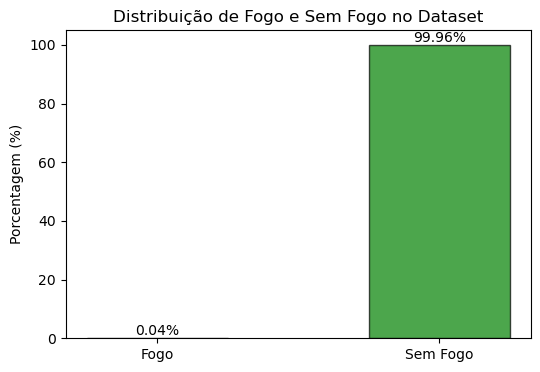

In [ ]:
# Calcular as frações de fogo (1) e sem fogo (0)
fire_fraction = (ratios.sum() / len(ratios)) * 100
no_fire_fraction = 100 - fire_fraction

# Dados para o gráfico
fractions = [fire_fraction, no_fire_fraction]
labels = ["Fogo", "Sem Fogo"]

# Ajuste para aproximar as barras
x_pos = [0, 1]  # Posições para as barras
bar_width = 0.5  # Ajuste da largura das barras

# Criar o gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(x_pos, fractions, color=["red", "green"], edgecolor="black", alpha=0.7, width=bar_width)

# Adicionar rótulos e título
plt.ylabel("Porcentagem (%)")
plt.title("Distribuição de Fogo e Sem Fogo no Dataset")

# Adicionar as labels
plt.xticks(x_pos, labels)

# Exibir os valores no topo das barras
for i in range(len(fractions)):
    plt.text(x_pos[i], fractions[i] + 1, f"{fractions[i]:.2f}%", ha="center")

plt.show()

## Modelo Para Segmentação de Focos de Incêndio

In [19]:
class FireModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, lr=1e-4, **kwargs):
        super(FireModel, self).__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.arch = arch.lower()
        self.save_hyperparameters()

        # for image segmentation dice loss could be the best first choice
        self.criterion = smp.losses.FocalLoss(smp.losses.BINARY_MODE, normalized=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    # ===================== TREINAMENTO =======================

    def training_step(self, batch, batch_idx):
        """ Passo de treinamento """
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y.float())

        self.training_step_outputs.append(loss)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    # ===================== OTIMIZADOR =======================

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }


    def on_train_epoch_end(self):
        epoch_average = torch.mean(torch.tensor(self.training_step_outputs))

        # Log da média de perda de treinamento no final da época
        self.log("training_epoch_average", epoch_average)

        self.training_step_outputs.clear()  # Free memory

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y.float()).detach()
        self.validation_step_outputs.append(loss)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)

        return loss

    def on_validation_epoch_end(self):
        epoch_average = torch.mean(torch.tensor(self.validation_step_outputs))
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y.float())
        self.test_step_outputs.append(loss)
        return loss


    def on_test_epoch_end(self):
        epoch_average = torch.mean(torch.tensor(self.test_step_outputs))
        self.log("test_epoch_average", epoch_average)
        self.test_step_outputs.clear()

## Treinamento

In [6]:
# Definição do Dataset personalizado
class FireSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_ds = gdal.Open(str(self.img_paths[idx]))
        nir = img_ds.GetRasterBand(5).ReadAsArray().astype(np.float32)
        swir = img_ds.GetRasterBand(7).ReadAsArray().astype(np.float32)
        tir = img_ds.GetRasterBand(9).ReadAsArray().astype(np.float32)

        nbr = (nir - swir) / (nir + swir + 1e-6)
        del nir
        gc.collect()

        # Reescalando o NBR para [0, 255]
        nbr_scaled = ((nbr + 1) / 2 * 255).astype(np.uint8)

        # Normalizar TIRS e SWIR para [0, 255]
        tir_scaled = (tir / (tir.max() + 1e-6) * 255).astype(np.uint8)
        swir_scaled = (swir / (swir.max() + 1e-6) * 255).astype(np.uint8)

        # Criar imagem RGB com TIRS, SWIR e NBR
        rgb = np.stack([tir_scaled, swir_scaled, nbr_scaled], axis=-1)

        # Equalizar histograma
        rgb = np.stack([cv2.equalizeHist(rgb[:, :, j]) for j in range(3)], axis=-1)
        rgb = rgb / 255.0

        mask_ds = gdal.Open(str(self.mask_paths[idx]))
        mask = mask_ds.ReadAsArray().astype(np.uint8)

        rgb = torch.tensor(rgb).float()
        mask = torch.tensor(mask).long()

        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)

        if self.transform:
            rgb = self.transform(rgb)

        return rgb, mask


# Definição das transformações (ex: augmentação)
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
])

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Combina treino e validação para cross-validação
all_img_paths = X_train + X_val
all_mask_paths = y_train + y_val

num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
architectures =  ["unet", "deeplabv3plus", "segformer"]

for arch in architectures:
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_img_paths)):
        model = FireModel(arch, "efficientnet-b0", 3, 1) #resnet34
        print(f"\nFold {fold + 1}/{num_folds}")

        # Cria subsets para o fold atual
        train_img = [all_img_paths[i] for i in train_idx]
        train_mask = [all_mask_paths[i] for i in train_idx]
        val_img = [all_img_paths[i] for i in val_idx]
        val_mask = [all_mask_paths[i] for i in val_idx]

        # Cria datasets e dataloaders
        train_dataset = FireSegmentationDataset(train_img, train_mask, transform)
        val_dataset = FireSegmentationDataset(val_img, val_mask, transform=None)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count()//2,persistent_workers=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count()//2, persistent_workers=True)

        # Callbacks específicos do fold
        checkpoint_callback = ModelCheckpoint(
            monitor='validation_epoch_average',
            dirpath=f'checkpoints/{arch}_fold_{fold}',  # Adicione o nome da arquitetura
            filename="best_model",
            save_top_k=1,
            mode='min'
        )
        lr_scheduler_callback = LearningRateMonitor(logging_interval='step')

        early_stop_callback = EarlyStopping(
            monitor='validation_epoch_average',  # Monitorando a perda de validação
            patience=3,                          # Número de épocas sem melhoria para parar
            #verbose=True,                        # Exibe mensagens de log quando ocorrer o early stopping
            mode='min'                           # Estamos tentando minimizar a perda
        )
        logger = TensorBoardLogger("tb_logs", name=f"{model.arch}_fold_{fold}")

        # Configura o Trainer
        trainer = pl.Trainer(
            max_epochs=100,
            callbacks=[early_stop_callback, checkpoint_callback, lr_scheduler_callback],
            logger=logger,
            accelerator="auto",
            log_every_n_steps=1,
            precision=16
        )

        # Treina o modelo no fold atual
        trainer.fit(model, train_loader, val_loader)

        # Check if early stopping was triggered
        if early_stop_callback.stopped_epoch != 0:
            print(f"Early stopping triggered at epoch {early_stop_callback.stopped_epoch}")

## Testes/Inferência

In [ ]:
test_dataset = FireSegmentationDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Carrega os melhores modelos de cada fold
models = []
for fold in range(num_folds):
    model_path = f'checkpoints/fold_{fold}/best_model.ckpt'
    model = FireModel.load_from_checkpoint(model_path)
    models.append(model)

# Avalia cada modelo no conjunto de teste
results = []
for model in models:
    result = trainer.test(model, test_loader)
    results.append(result)

FileNotFoundError: [Errno 2] No such file or directory: '/home/phvguimaraes/development/remote-sensing/fire_segmentation/checkpoints/fold_0/best_model.ckpt'